In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization #For tokenizing and vectorizing 

# Processing the string 
import re
import string

# To view results pictorially 
import matplotlib.pyplot as plt

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'test', 'imdbEr.txt', 'README']

## Read the positive and negative reviews

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'urls_unsup.txt',
 'unsup',
 'unsupBow.feat',
 'neg',
 'urls_neg.txt',
 'pos',
 'urls_pos.txt']

In [ ]:
positive_reviews_folder = os.path.join(train_dir, 'pos')
negative_reviews_folder = os.path.join(train_dir, 'neg')
# !ls {negative_reviews_folder}
# !ls {positive_reviews_folder} #shows the texfiles that has positive reviews

In [ ]:
sample_positive_reviews_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_positive_reviews_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [ ]:
sample_negative_reviews_file = os.path.join(train_dir, 'neg/10001_4.txt')
with open(sample_negative_reviews_file) as f:
    print(f.read())

This film lacked something I couldn't put my finger on at first: charisma on the part of the leading actress. This inevitably translated to lack of chemistry when she shared the screen with her leading man. Even the romantic scenes came across as being merely the actors at play. It could very well have been the director who miscalculated what he needed from the actors. I just don't know.<br /><br />But could it have been the screenplay? Just exactly who was the chef in love with? He seemed more enamored of his culinary skills and restaurant, and ultimately of himself and his youthful exploits, than of anybody or anything else. He never convinced me he was in love with the princess.<br /><br />I was disappointed in this movie. But, don't forget it was nominated for an Oscar, so judge for yourself.


In [ ]:
import shutil
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir) #the dataset contains unwanted folder

View the train directory after delete.

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'urls_unsup.txt',
 'unsupBow.feat',
 'neg',
 'urls_neg.txt',
 'pos',
 'urls_pos.txt']

##Load the train dataset

In [ ]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed
)
raw_train_ds

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

View the class names of loaded train dataset

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


View the train dataset

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print(f"Review: {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}")
        print()

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label: 0

Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get i

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# Load the test dataset
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Prepare the dataset for training
The reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn’t strip HTML). You will write a custom standardization function to remove the HTML.

In [ ]:

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

##Standardize, tokenize, and vectorize the data

In [ ]:
#This process is similar to what is generally made for any NLP, tokenize and vectorize  the data or better handling. THe output changes with the data you use

In [ ]:
max_features = 10000
sequence_length = 250
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length) #it is set to int to create unique indices for each token

Next, we will call adapt to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.
Note: it’s important to only use training data when calling adapt.

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [ ]:
# Retrieve a batch of 32 reviews and labels from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [ ]:
# Each token has been replaced by an integer. We can see the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


Apply the TextVectorization layer to the train, validation, and test dataset

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

##Configure the dataset for performance
When loading data to make sure that I/O does not become blocking.
.cache() keeps data in memory after it’s loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
.prefetch() overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Create a model

In [ ]:
from tensorflow.keras import layers
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


##Compile the model

In [ ]:
from tensorflow.keras import losses
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

##Train the model

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 13s 20ms/step - loss: 0.6641 - binary_accuracy: 0.6957 - val_loss: 0.6142 - val_binary_accuracy: 0.7752
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5475 - binary_accuracy: 0.8028 - val_loss: 0.4974 - val_binary_accuracy: 0.8230
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4441 - binary_accuracy: 0.8445 - val_loss: 0.4197 - val_binary_accuracy: 0.8468
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3782 - binary_accuracy: 0.8658 - val_loss: 0.3737 - val_binary_accuracy: 0.8618
Epoch 5/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3356 - binary_accuracy: 0.8795 - val_loss: 0.3453 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3055 - binary_accuracy: 0.8877 - val_loss: 0.3263 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] - 5s 8ms/s

In [ ]:
##Evaluate the model on test dataset

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3106 - binary_accuracy: 0.8729
Loss:  0.3105883300304413
Accuracy:  0.8728799819946289


In [ ]:
##Plot accuracy and loss
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [ ]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

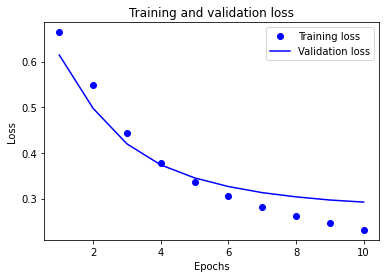

In [ ]:
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

##Plot training and validation accuracy

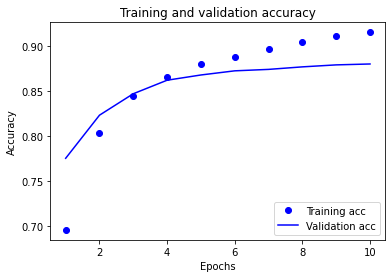

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

##Export the model
If we want to make our model capable of processing raw strings, we can include the TextVectorization layer inside our model. For that we will create a new model using the weights we just trained.

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3106 - accuracy: 0.8729
0.8728799819946289


##Predict on new data

In [94]:
test_reviews = [
  "The movie was great!",
  "The movie was excelllent",
  "The movie was outstanding. I would like to watch again...",
  "The movie was terrible... total waste of money...",
  "The most amazing app ever. I especially enjoyed it.",
  "The best app in the world"
]

##Predict test reviews

In [95]:
predictions = export_model.predict(test_reviews)
predictions

array([[0.60210186],
       [0.47842512],
       [0.5738576 ],
       [0.10182983],
       [0.81024635],
       [0.6528087 ]], dtype=float32)

3


Text(0.1, 0.4, 'The best app in the world')

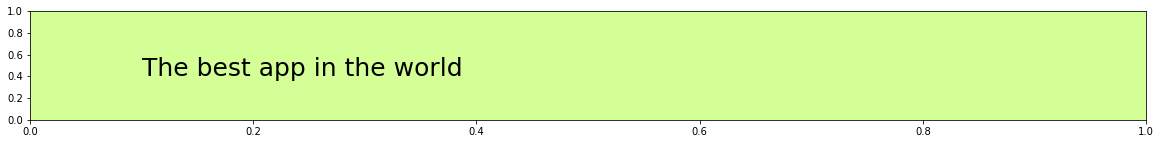

In [96]:
clrstr = ['#ff9977', '#ffce91', '#fff783', '#d4ff97', '#8cff9b']
this_color = int((predictions[-1]*5)[0])
print(this_color)
plt.figure(figsize=[20,2])
ax = plt.gca()
ax.set_facecolor(clrstr[this_color])
plt.text(0.1, 0.4, test_reviews[-1], size=25)

In [ ]:
export_model.save('sa1model.tf')


INFO:tensorflow:Assets written to: sa1model.tf/assets


In [93]:
from google.colab import files
files.download('sa1model.tf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>